## Import des données et pré-traitement

In [1]:
import pandas as pd
from src.utility.descriptive_statistics import descriptive_statistics

df = pd.read_pickle('src/data/panel_data.pkl')
df["index"] = pd.to_datetime(df["index"])

outlier_dates = [pd.Timestamp('2001-09-11')]
df = df[~df['index'].isin(outlier_dates)]

df = df[(df['index'] >= '1988-01-01') & (df['index'] <= '2017-01-01')]

for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df

,index,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5
0,1988-01-04,187.50,193.50,198.25,200.00,202.75
1,1988-01-05,187.50,193.25,197.25,198.25,200.75
2,1988-01-06,191.00,195.75,199.75,201.75,204.50
3,1988-01-07,192.75,198.75,202.75,204.50,208.50
4,1988-01-08,192.50,198.00,202.00,203.50,207.25
...,...,...,...,...,...,...
7288,2016-12-23,345.75,352.50,360.00,367.25,376.25
7289,2016-12-27,355.00,361.25,368.50,375.75,384.25
7290,2016-12-28,348.25,354.75,362.00,369.25,378.25
7291,2016-12-29,349.75,355.75,363.00,370.25,379.25


## Statistiques descriptives

In [2]:
import numpy as np

original_stats, log_stats = descriptive_statistics(df["Maturity 1"])

stats_keys = ['Mean', 'Median', 'Minimum', 'Maximum', 'Std deviation', 'Skewness', 'Kurtosis', 'Autocorrelation', 'ADF test p-value (10 lags)', 'Nb obs']
df_combined_stats = pd.DataFrame(index=stats_keys, columns=['Prices (c/bu)', 'Log returns'])

for key in stats_keys:
    df_combined_stats.loc[key, 'Prices (c/bu)'] = original_stats.get(key, np.nan)
    log_key = 'Log ' + key  
    df_combined_stats.loc[key, 'Log returns'] = log_stats.get(log_key, np.nan)
df_combined_stats

,Prices (c/bu),Log returns
Mean,328.0151,0.0001
Median,269.1875,0.0
Minimum,174.75,-0.272
Maximum,831.25,0.128
Std deviation,143.9133,0.0172
Skewness,1.53,-1.04
Kurtosis,1.57,19.59
Autocorrelation,0.999,0.05
ADF test p-value (10 lags),0.16,0.0
Nb obs,7312,7311


## Graphiques


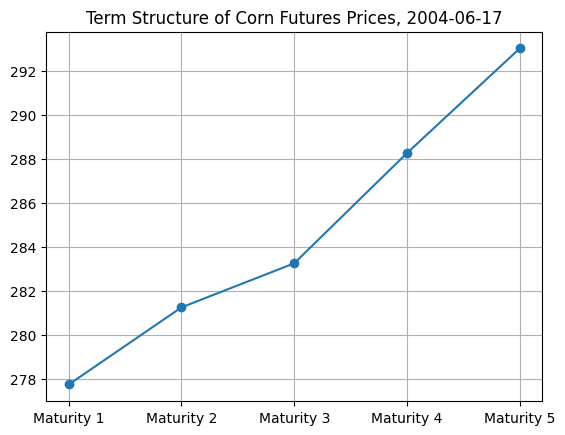

In [3]:
import matplotlib.pyplot as plt
import os 

df.set_index('index', inplace=True)

target_date = '2004-06-17'

prix_17_06_2004 = df.loc[target_date, ['Maturity 1', 'Maturity 2', 'Maturity 3', 'Maturity 4', 'Maturity 5']]

plt.plot(['Maturity 1', 'Maturity 2', 'Maturity 3', 'Maturity 4', 'Maturity 5'], prix_17_06_2004 , marker='o', linestyle='-')
plt.title(f'Term Structure of Corn Futures Prices, {target_date}')
plt.grid()

output_dir = 'static/graph'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, f'term_structure_{target_date}.png')
plt.savefig(output_path)
plt.show()


In [ ]:
'''from src.graph.graph import plot_and_save_graph

plot_and_save_graph(df, ["Maturity 1"], 
                    "Front-month settlement price (cents/bu)", 
                    "Dates", "cents/bu", 
                    output_filename='price_history.png', 
                    output_dir='static/graph')'''

# Estimation du modele espace d'etat


## Preparation des données

In [4]:

import pandas as pd
import numpy as np
from src.utility.date import get_T, get_t, get_t_2
df.index = pd.to_datetime(df.index)
df[['T1', 'T2', 'T3', 'T4', 'T5']] = pd.DataFrame(df.index.map(lambda x: pd.Series(get_T(x))).tolist(), index=df.index)
for i in range(1, 6):
    df[f'Maturity {i}'] = np.log(df[f'Maturity {i}'])
df
df = df[(df.index >= '1988-02-01') & (df.index <= '2015-01-01')]

df['t'] = df.index.to_series().apply(get_t)
df


C:\Users\bossd\AppData\Local\Temp\ipykernel_58020\2626935099.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['t'] = df.index.to_series().apply(get_t)


,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5,T1,T2,T3,T4,T5,t
index,,,,,,,,,,,
1988-02-01,5.287004,5.316894,5.331510,5.339939,5.349486,0.117808,0.284932,0.452055,0.619178,0.871233,0.084932
1988-02-02,5.289529,5.316894,5.331510,5.335131,5.345916,0.115068,0.282192,0.449315,0.616438,0.868493,0.087671
1988-02-03,5.292048,5.318120,5.333926,5.338739,5.353042,0.112329,0.279452,0.446575,0.613699,0.865753,0.090411
1988-02-04,5.311974,5.336335,5.350673,5.358942,5.375278,0.109589,0.276712,0.443836,0.610959,0.863014,0.093151
1988-02-05,5.304548,5.332719,5.349486,5.356586,5.367144,0.106849,0.273973,0.441096,0.608219,0.860274,0.095890
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,6.010654,6.031286,6.047372,6.055026,6.069004,0.221918,0.389041,0.556164,0.723288,0.975342,26.997260
2014-12-26,6.027676,6.047372,6.063204,6.069582,6.084499,0.216438,0.383562,0.550685,0.717808,0.969863,27.002740
2014-12-29,6.022842,6.043226,6.059123,6.065528,6.079361,0.208219,0.375342,0.542466,0.709589,0.961644,27.010959


In [7]:
from src.model.wavelet import apply_wavelet_decomposition, threshold_coeffs, reconstruct_signal_from_coeffs


# Calculer le seuil universel basé sur l'écart absolu médian (MAD)
def calculate_universal_threshold(coeffs, data_length):
    sigma_mad = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = np.sqrt(2 * sigma_mad**2 * np.log(data_length))
    return threshold

# Enlever les 16 premières et 16 dernières lignes pour éviter les effets de bord
df_filtered = df.iloc[16:-16].copy()

# Initialiser un nouveau dataframe pour les données filtrées
filtered_maturities = pd.DataFrame(index=df_filtered.index)

# Appliquer les transformations par ondelettes uniquement sur les colonnes de maturité
maturity_columns = [f'Maturity {i}' for i in range(1, 6)]
for col in maturity_columns:
    data = df_filtered[col].values
    coeffs = apply_wavelet_decomposition(data)
    threshold = calculate_universal_threshold(coeffs, len(data))
    thresholded_coeffs = threshold_coeffs(coeffs, threshold)
    filtered_data = reconstruct_signal_from_coeffs(thresholded_coeffs)
    
    # Ajouter les données filtrées au nouveau dataframe
    filtered_maturities[col] = filtered_data

# Fusionner les colonnes filtrées avec les colonnes T1, T2, T3, T4, T5 et t
filtered_df = pd.concat([filtered_maturities, df_filtered[['T1', 'T2', 'T3', 'T4', 'T5', 't']]], axis=1)

# Afficher le dataframe filtré
filtered_df

,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5,T1,T2,T3,T4,T5,t
index,,,,,,,,,,,
1988-02-24,5.310013,5.342797,5.361116,5.371246,5.391286,0.054795,0.221918,0.389041,0.556164,0.808219,0.147945
1988-02-25,5.310013,5.342797,5.361116,5.371246,5.391286,0.052055,0.219178,0.386301,0.553425,0.805479,0.150685
1988-02-26,5.310013,5.342797,5.361116,5.371246,5.391286,0.049315,0.216438,0.383562,0.550685,0.802740,0.153425
1988-02-29,5.310013,5.342797,5.361116,5.371246,5.391286,0.041096,0.208219,0.375342,0.542466,0.794521,0.161644
1988-03-01,5.310013,5.342797,5.361116,5.371246,5.391286,0.038356,0.205479,0.372603,0.539726,0.791781,0.164384
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-02,5.919927,5.954099,5.976568,5.994606,6.009876,0.282192,0.449315,0.616438,0.783562,1.035616,26.936986
2014-12-03,5.921982,5.956991,5.979017,5.995850,6.007404,0.279452,0.446575,0.613699,0.780822,1.032877,26.939726
2014-12-04,5.921982,5.956991,5.979017,5.995850,6.007404,0.276712,0.443836,0.610959,0.778082,1.030137,26.942466


In [9]:
df = filtered_df

## Estimation du modèle espace d'Etat

In [10]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize
from tqdm import tqdm
from src.model.kalman import KalmanModel
from src.utility.parameter import calculate_num_parameters
from src.utility.parameter import mu, kappa, sigma1, sigma2, rho, lambdaz, x1

def objective(params, observations, times, maturities, n_factors):
    param_keys = ['x1_initial', 'mu', 'sigma1', 'lambda1', 'kappa2', 'sigma2', 'lambda2', 'rho12',
                  'kappa3', 'sigma3', 'lambda3', 'rho13', 'rho23',
                  'kappa4', 'sigma4', 'lambda4', 'rho14', 'rho24', 'rho34']
    num_params = calculate_num_parameters(n_factors) + 1  
    model_params = {
        key: params[i] for i, key in enumerate(param_keys[:num_params])
    }
    model_params['maturities'] = maturities
    model_params['current_time'] = times

    model = KalmanModel(n_factors=n_factors, params=model_params)
    return model.compute_likelihood(observations, times, maturities)


observations = df.iloc[:, 0:5].values
maturities = df.iloc[:, 6:11].values
times = df['t'].values

initial_guesses = {
    1: [x1, mu, sigma1, lambdaz],
    2: [x1, mu, sigma1, lambdaz, kappa, sigma2, lambdaz, rho],
    3: [x1, mu, sigma1, lambdaz, kappa, sigma2, lambdaz, rho, kappa, sigma2, lambdaz, rho, rho],
    4: [x1, mu, sigma1, lambdaz, kappa, sigma2, lambdaz, rho, kappa, sigma2, lambdaz, rho, rho, kappa, sigma2, lambdaz, rho, rho, rho]
}

results = {}
for n_factors in tqdm(range(1, 5)):
    initial_result = minimize(
        objective,
        initial_guesses[n_factors],
        args=(observations, times, maturities, n_factors),
        method='Nelder-Mead',
        options={'maxiter': 50}
    )

    final_result = minimize(
        objective,
        initial_result.x,
        args=(observations, times, maturities, n_factors),
        method='BFGS',
        options={'maxiter': 3, 'disp': True}
    )
    
    results[n_factors] = final_result
    print(f"Optimized parameters for {n_factors} factors:", final_result.x)

    hessian_inv = final_result.hess_inv
    if isinstance(hessian_inv, np.ndarray):
        covariance_matrix = hessian_inv
    else:
        covariance_matrix = hessian_inv.todense()

    std_errors = np.sqrt(np.diag(covariance_matrix))

    z_values = final_result.x / std_errors
    p_values = [2 * (1 - stats.norm.cdf(np.abs(z))) for z in z_values]

    num_params = calculate_num_parameters(n_factors) + 1  
    param_keys = ['x1_initial', 'mu', 'sigma1', 'lambda1', 'kappa2', 'sigma2', 'lambda2', 'rho12',
                  'kappa3', 'sigma3', 'lambda3', 'rho13', 'rho23',
                  'kappa4', 'sigma4', 'lambda4', 'rho14', 'rho24', 'rho34']
    param_keys = param_keys[:num_params]

    for i, (param, std_err, p_value) in enumerate(zip(final_result.x, std_errors, p_values)):
        print(f"Parameter {param_keys[i]}: estimate={param}, std_error={std_err}, p_value={p_value}")


  0%|          | 0/4 [00:00<?, ?it/s]c:\Joudy\GQ2\Gestion-Quantitative-2\.venv\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 25%|██▌       | 1/4 [06:01<18:03, 361.16s/it]

         Current function value: -42938.592346
         Iterations: 3
         Function evaluations: 45
         Gradient evaluations: 9
Optimized parameters for 1 factors: [ 5.86147902  0.04884185  0.15198952 -0.034679  ]
Parameter x1_initial: estimate=5.861479024140703, std_error=1.0, p_value=4.587624280461e-09
Parameter mu: estimate=0.04884184716043108, std_error=0.0016627518581072555, p_value=0.0
Parameter sigma1: estimate=0.15198951763990765, std_error=0.003740765364864501, p_value=0.0
Parameter lambda1: estimate=-0.03467900217842738, std_error=0.0017241807961431597, p_value=0.0


 50%|█████     | 2/4 [13:05<13:16, 398.08s/it]

         Current function value: -42379.849215
         Iterations: 3
         Function evaluations: 72
         Gradient evaluations: 8
Optimized parameters for 2 factors: [ 5.79105332  0.03777268  0.14656153 -0.02592627  0.73435142  0.20160813
 -0.09340733 -0.33344957]
Parameter x1_initial: estimate=5.791053315354503, std_error=1.0, p_value=6.994636647661423e-09
Parameter mu: estimate=0.0377726820279993, std_error=0.6967337653814119, p_value=0.9567647151041874
Parameter sigma1: estimate=0.14656152579632684, std_error=0.858105671095074, p_value=0.8643837074263496
Parameter lambda1: estimate=-0.025926268961506852, std_error=0.7390585419527005, p_value=0.9720158464505866
Parameter kappa2: estimate=0.7343514167153509, std_error=1.0002196101907475, p_value=0.4628328369578725
Parameter sigma2: estimate=0.20160812754489937, std_error=0.5914523423989161, p_value=0.7332017460694251
Parameter lambda2: estimate=-0.09340733366953097, std_error=0.34271608790705615, p_value=0.7851990079776343
Para

 50%|█████     | 2/4 [17:22<17:22, 521.47s/it]


KeyboardInterrupt: 

In [13]:
from src.model.performance import calculate_performance


# Example usage with your optimized parameters
optimized_params_1 = [5.861479024140703, 0.04884184716043108, 0.15198951763990765, -0.03467900217842738]
param_keys_1 = ['x1_initial','mu', 'sigma1', 'lambda1']

optimized_params_2 = [5.791053315354503, 0.0377726820279993, 0.14656152579632684, -0.025926268961506852, 0.7343514167153509, 0.20160812754489937, -0.09340733366953097, -0.3334495702475448]
param_keys_2 = ['x1_initial', 'mu', 'sigma1', 'lambda1', 'kappa2', 'sigma2', 'lambda2', 'rho12']


print("Calculating performance for 1-factor model...")
calculate_performance(1, optimized_params_1, param_keys_1, observations, times, maturities)

print("Calculating performance for 2-factor model...")
calculate_performance(2, optimized_params_2, param_keys_2, observations, times, maturities)

Calculating performance for 1-factor model...
RMSE for 1 factors, Maturity 1: 1.01%
RMSE for 1 factors, Maturity 2: 1.00%
RMSE for 1 factors, Maturity 3: 1.00%
RMSE for 1 factors, Maturity 4: 1.00%
RMSE for 1 factors, Maturity 5: 2.36%
Calculating performance for 2-factor model...
RMSE for 2 factors, Maturity 1: 0.81%
RMSE for 2 factors, Maturity 2: 0.81%
RMSE for 2 factors, Maturity 3: 0.81%
RMSE for 2 factors, Maturity 4: 0.82%
RMSE for 2 factors, Maturity 5: 1.92%


In [5]:
from src.model.wavelet import apply_wavelet_decomposition
from src.model.wavelet import threshold_coeffs
from src.model.wavelet import reconstruct_signal_from_coeffs

def calculate_universal_threshold(coeffs, data_length):
    """
    Calcule le seuil universel basé sur l'écart absolu médian (MAD).

    Parameters:
    coeffs (list): Coefficients de la décomposition par ondelettes.
    data_length (int): Longueur de la série de données.

    Returns:
    float: Seuil calculé.
    """
    sigma_mad = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = np.sqrt(2 * sigma_mad**2 * np.log(data_length))
    return threshold

# Enlever les 16 premières et 16 dernières lignes
df_filtered = df.iloc[16:-16].reset_index(drop=True)

# Initialiser un nouveau dataframe pour les données filtrées
filtered_df = pd.DataFrame()
filtered_df['index'] = df_filtered['index']  # Conserver les dates

# Appliquer les transformations par ondelettes sur chaque colonne de maturité
for col in df_filtered.columns[1:]:  # Ignorer la colonne 'index'
    data = df_filtered[col].values
    coeffs = apply_wavelet_decomposition(data)
    threshold = calculate_universal_threshold(coeffs, len(data))
    thresholded_coeffs = threshold_coeffs(coeffs, threshold)
    filtered_data = reconstruct_signal_from_coeffs(thresholded_coeffs)
    
    # Ajouter les données filtrées au nouveau dataframe
    filtered_df[col] = filtered_data

# Afficher le dataframe filtré
print(filtered_df)

KeyError: 'index'